In [19]:
import numpy as np
import cPickle as pickle
import pandas as pd
import json
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import random

In [38]:
mean_sentiment = "../Logs/instaMedianSenti.csv"
aesthetic_csv = "../Logs/insta6000AesMedian.csv"
audio_csv = "../Logs/instaPop_audio.csv"
socialFeatures = "../Logs/instaSample6000stats.json"
faceFeats = "../Logs/instaFaceCounts.pk"

In [96]:
def readFeatureFile(color_features):
    with open(color_features) as g:
        featureLines = g.readlines()
    print len(featureLines)
    return featureLines


def readFaceCounts(fileName):
    lists = []
    infile = open(fileName, 'rb')
    while True:
        try:
            lists.append(pickle.load(infile))
        except EOFError:
            infile.close()
            break
    return lists

def removeDuplicatesAndSplit(lines):
    posts = []
    totFrames = []
    faceFrames = []
    profiles = []
    frontals = []
    for l in lines:
        comps = l.split(',')
        postId = comps[0]
        if postId in posts:
            break
        else:
            posts.append(postId)
            if int(comps[1]) == 0:
                totFrames.append(1)
            else:
                totFrames.append(int(comps[1]))
            faceFrames.append(int(comps[2]))
            profiles.append(int(comps[3]))
            frontals.append(int(comps[3]))
    return totFrames, faceFrames , posts
            

def readAudioFeatures(lines):
    featureDict = {}
    
    for line in lines:
        components = line.strip().split(',')
        postId = components[0].strip().split('/')[-1].split('.')[0]
        feats = [float(x) for x in components[1:]]
        cleanFeats = []
        for x in feats:
            if str(x) != 'nan':
                cleanFeats.append(float(x))
            else:
                cleanFeats.append(0.0)
        featureDict[postId] = cleanFeats
            
    return featureDict

def readSentiFeatures(lines):
    sentiDict = {}
    for line in lines:
        comp = line.strip().split(',')
        sentiDict[comp[0]] = float(comp[1].strip())
    return sentiDict

def mergeAllFeatures(aesthetic , sentiment , audio , social , face):
    totalMatrix = []
    for aes in aesthetic:
        if aes in sentiment:
            if aes in audio:
                if aes in social:
                    if aes in face:
                        postid = aes
                        aesVec = np.asarray(map(lambda x: float(x),aesthetic[postid][1:]) , dtype = "float32").reshape((1,-1))
                        audioVec = np.asarray(map(lambda x: float(x),audio[postid]) , dtype = "float32").reshape((1,-1))
                        sentimentVec = np.asarray(map(lambda x: float(x),[sentiment[postid]]) , dtype = "float32").reshape((1,-1))
                        faceVec = np.asarray(map(lambda x: float(x),[face[postid]]) , dtype = "float32").reshape((1,-1))
                        socialVec = np.asarray(map(lambda x: int(x),[social[postid]['follows'], social[postid]['followers'] , social[postid]['likes'] , social[postid]['views']]) , dtype = "int32" ).reshape((1,-1))

                        finalFeatureVec = np.concatenate((aesVec,audioVec,sentimentVec,faceVec, socialVec), axis = 1)
                        totalMatrix.append(finalFeatureVec)
    print len(totalMatrix)
    return np.vstack(totalMatrix)

def convertToDict(social):
    socialDict = {}
    print len(social)
    for i in social:
        social_feats = i[1:]
        key = i[0]
        socialDict[key] = social_feats 
    return socialDict

def faceConvertToDict(destDict , postList , percentageList):
    for i in range(len(postList)):
        destDict[postList[i]] = percentageList[i]
    return destDict

In [5]:
faceLines = readFaceCounts(faceFeats)
print len(faceLines)

6413


In [6]:
popTotFrames , popFaceFrames , popPosts = removeDuplicatesAndSplit(faceLines)
facePercentages = np.zeros((len(popTotFrames),1))
for i in range(len(facePercentages)):
    facePercentages[i] = float(float(popFaceFrames[i])/float(popTotFrames[i]))

In [7]:
faceDict = faceConvertToDict({}, popPosts , facePercentages)
print len(faceDict.keys())

6413


In [13]:
f = open(aesthetic_csv , "r+")
aesFeats = f.readlines()
f.close()


In [17]:
print aesFeats[1]
instaAes = dict()
for line in aesFeats:
    comps = line.strip().split(',')
    vId = comps[0].split('/')[-1]
    instaAes[vId] = comps[2:]
    

/datasets/sagarj/instaSample6000/finesamples/--P7gAogpb,0.0714285714286,0.504780363384,0.922576679586,1.0,0.0,0.707936879727,0.55983520352,1.0,0.00295275590551,0.0614853468976,0.922576679586,0.818199264535



In [175]:
print len(instaAes[instaAes.keys()[1]])

11


In [57]:
socialFeatures = json.load(open(socialFeatures , "rb"))

In [72]:
set( socialFeatures.keys() ) ^ set(faceDict.keys())

set()

In [58]:
set( socialFeatures.keys() ) ^ set(instaAes.keys())

{'0', u'BAi50GqR6Xs', u'ch4hrRJ8bG'}

In [59]:
popAudio_csv = readFeatureFile(audio_csv)

6107


In [60]:
popAudio_csv[1]

'--QO1FIgqK.wav,0.065059,0.291802,0.982013,0.028688,0.789000,1.000000\n'

In [61]:
totalFeats = popAudio_csv
audioDict = readAudioFeatures(totalFeats)

In [176]:
len(audioDict[audioDict.keys()[1]])

6

In [64]:
len(set(socialFeatures.keys()) ^ set(audioDict.keys()))

306

In [68]:
senti_csv = readFeatureFile(mean_sentiment)
sentiDict = readSentiFeatures(senti_csv)

6411


In [70]:
print socialFeatures[socialFeatures.keys()[1]]

{u'follows': 68, u'length': u'6.572000', u'followers': 1564, u'likes': 62, u'views': 0}


In [ ]:
socialDict = dict()
for k in socialFeatures: 
    

In [97]:
totMatrix = mergeAllFeatures(instaAes , sentiDict , audioDict , socialFeatures , faceDict)
#totMatrix_thirds = mergeAllFeatures(aesFeats_Thirds , sentiDictThirds , audioDict , socialDict , faceDict)

6105


In [148]:
totMatrix.shape

(6105, 22)

In [98]:
print "Median Likes: %f , median views %f "%(np.median(totMatrix[:,-2]) , np.median(totMatrix[:,-1]))

Median Likes: 92.000000 , median views 50.000000 


In [242]:
np.percentile(totMatrix[:,-1], 90)

34671.600000000166

In [243]:
popFaces = totMatrix[np.where(totMatrix[:,-1]>34671),17]

In [244]:
np.median(popFaces[:])

0.44897958636283875

In [245]:
unpopFaces = totMatrix[np.where(totMatrix[:,-1]<34671),17]

In [246]:
np.median(unpopFaces[:])

0.32047741115093231

In [247]:
popFaces.shape

(1, 611)

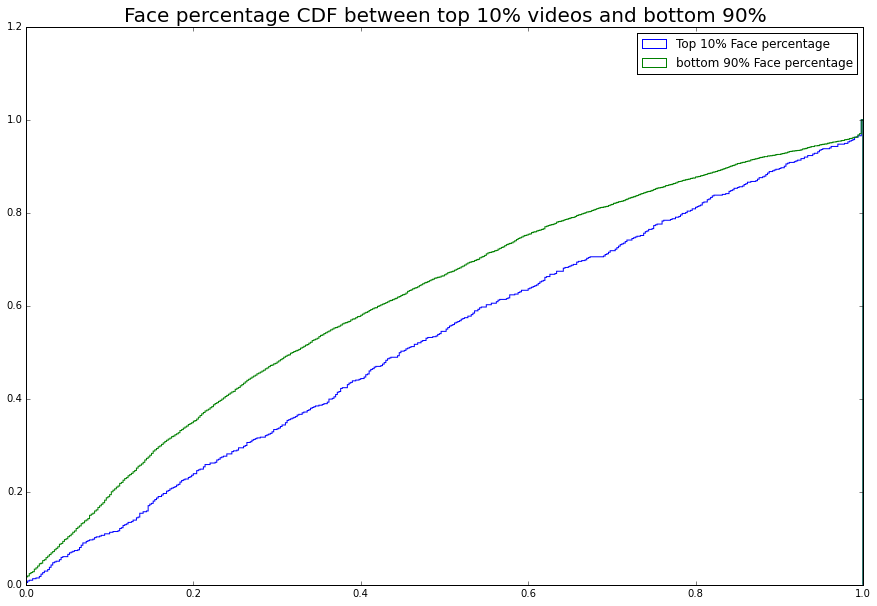

In [248]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(popFaces[0,:], 500 ,normed = 1 , cumulative = True, histtype='step' , label='Top 10% Face percentage')
plt.hist(unpopFaces[0,:], 500 ,normed = 1 , cumulative = True, histtype='step' , label='bottom 90% Face percentage')
plt.title("Face percentage CDF between top 10% videos and bottom 90%",fontsize = 20)
plt.legend(loc='upper right')
plt.show()

In [100]:
print totMatrix.shape

(6105, 22)


In [101]:
FeatureMatrix = totMatrix[:,:-2] 
labelNumbers = totMatrix[:,-2:]

In [102]:
print FeatureMatrix.shape , labelNumbers.shape

(6105, 20) (6105, 2)


In [106]:
print np.mean(labelNumbers[:,0]) , np.mean(labelNumbers[:,1]) 

5309.44422604 36359.6416052


In [249]:
scipy.stats.pearsonr(labelNumbers[:,0] , labelNumbers[:,1])

(0.92220295974887212, 0.0)

In [107]:
medianPopLikes = 92.0
meanPopLikes = 5309.0

medianPopLoops = 50.0
meanPopLoops = 36359.0

In [115]:
def createLabels(labelNumbers , variable , threshold , scalar):
    Labels = np.zeros(labelNumbers.shape[0])
    for i in range(labelNumbers.shape[0]):
        if labelNumbers[i][variable] > (scalar*threshold):
            Labels[i] = 1
    return Labels

def balanceDataset(featureMatrix , BinaryLabels):
    positiveSamples = np.where(BinaryLabels[:] > 0)[0]
    negativeSamples = np.where(BinaryLabels[:] == 0)[0]
    print len(positiveSamples)
    sampledNegs = random.sample(negativeSamples, len(positiveSamples) )
    posFeats = featureMatrix[positiveSamples,:]
    negFeats = featureMatrix[sampledNegs,:]
    
    posLabels = BinaryLabels[positiveSamples]
    negLabels = BinaryLabels[sampledNegs]
    print posFeats.shape , negFeats.shape , posLabels.shape , negLabels.shape
    balancedFeats = np.concatenate((posFeats,negFeats), axis = 0)
    balancedLabels = np.concatenate((posLabels,negLabels), axis = 0)
    print balancedFeats.shape , balancedLabels.shape
    return balancedFeats,balancedLabels
    
def iterateTraining(FeatureMatrix , labelNumbers , variable , start , stop , steps):
    intervals = (stop-start)/steps
    divisions = np.arange(start, stop , intervals )
    fscores = []
    precisions = []
    recalls = []
    feature_importance = []
    accuracies = []
    errors = []
    for d in divisions: 
        LoopLabels = createLabels(labelNumbers ,  variable , d , 1)
        print LoopLabels.shape
        print FeatureMatrix.shape
        balancedX, balancedY = balanceDataset(FeatureMatrix , LoopLabels)
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(balancedX, balancedY, test_size=0.1, random_state=0)
        clfRF = RandomForestClassifier(n_estimators=1000 , max_features = 'sqrt', random_state = 9386)
        clfRF.fit(X_train, y_train)
        RF_predict = clfRF.predict(X_test)
        
        print "Videos Classified as Popular %f at Threshod %f "%(np.sum(LoopLabels)/LoopLabels.shape[0],d)
        
        error_RF = mean_squared_error(y_test, RF_predict)
        errors.append(error_RF)
        
        accuracy = np.mean(y_test == RF_predict)
        accuracies.append(accuracy)
        
        feature_importance.append(clfRF.feature_importances_)
        
        precision , recall , fscore , _ = precision_recall_fscore_support(y_test, RF_predict, average='binary')
        fscores.append(fscore)
        precisions.append(precision)
        recalls.append(recall)
        
    return accuracies, errors , fscores, precisions, recalls,  np.vstack(feature_importance)

def findIterativeCorrelations(FeatureMatrix , LabelNumbers , variable, control, start , stop , steps ):
    intervals = (stop-start)/steps
    divisions = np.arange(start, stop , intervals )
    correlations = []
    pValues = []
    for i in divisions: 
        LoopLabels = createLabels(labelNumbers ,  variable , i , 1)
        corrs = scipy.stats.pointbiserialr(LoopLabels , FeatureMatrix[:,control])
        correlations.append(corrs[0])
        pValues.append(corrs[1])
    return correlations, pValues
        
    

In [169]:
accuracies_total, errors_total , fscores_total, precision_total, recall_total, feature_importance_total  = \
iterateTraining(FeatureMatrix , labelNumbers , 1 , medianPopLoops , 50*medianPopLoops , 30)

(6105,)
(6105, 20)
3050
(3050, 20) (3050, 20) (3050,) (3050,)
(6100, 20) (6100,)
Videos Classified as Popular 0.499590 at Threshod 50.000000 
(6105,)
(6105, 20)
2684
(2684, 20) (2684, 20) (2684,) (2684,)
(5368, 20) (5368,)
Videos Classified as Popular 0.439640 at Threshod 131.666667 
(6105,)
(6105, 20)
2483
(2483, 20) (2483, 20) (2483,) (2483,)
(4966, 20) (4966,)
Videos Classified as Popular 0.406716 at Threshod 213.333333 
(6105,)
(6105, 20)
2333
(2333, 20) (2333, 20) (2333,) (2333,)
(4666, 20) (4666,)
Videos Classified as Popular 0.382146 at Threshod 295.000000 
(6105,)
(6105, 20)
2234
(2234, 20) (2234, 20) (2234,) (2234,)
(4468, 20) (4468,)
Videos Classified as Popular 0.365930 at Threshod 376.666667 
(6105,)
(6105, 20)
2128
(2128, 20) (2128, 20) (2128,) (2128,)
(4256, 20) (4256,)
Videos Classified as Popular 0.348567 at Threshod 458.333333 
(6105,)
(6105, 20)
2039
(2039, 20) (2039, 20) (2039,) (2039,)
(4078, 20) (4078,)
Videos Classified as Popular 0.333989 at Threshod 540.000000 


In [139]:
# accuracies_total_thirds, errors_total_thirds , fscores_total_thirds, precision_total_thirds, recall_total_thirds,\
# feature_importance_total_thirds  = \
# iterateTraining(FeatureMatrix_thirds , labelNumbers_thirds , 0 , 80.0 , 1.7*medianPopLoops , 30)

In [170]:
feature_importance_total.shape

(30, 20)

In [172]:

steps = 30
x = np.array(np.arange(medianPopLoops , 50*medianPopLoops ,  49*medianPopLoops / 30 ))
# y = np.arange(0,1.1,0.1)
len(x)

30

In [177]:
content_feature_importance = [np.sum(feature_importance_total[i,:18]) for i in range(feature_importance_total.shape[0])]
social_feature_importance = [np.sum(feature_importance_total[i,18:]) for i in range(feature_importance_total.shape[0])]
#post_feature_importance = [np.sum(feature_importance_total[i,19]) for i in range(feature_importance_total.shape[0])]


30 30


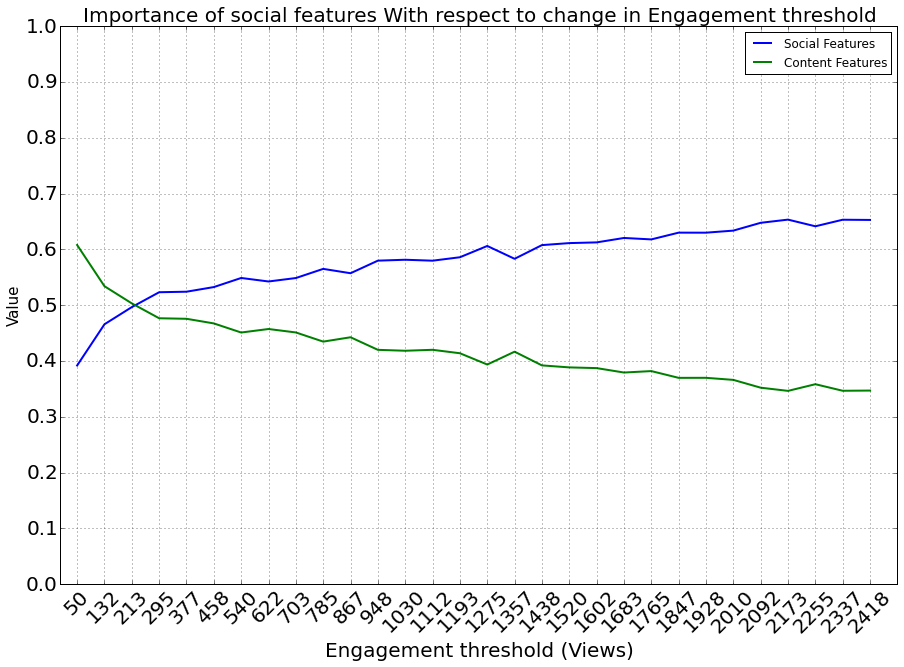

In [185]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Importance of social features With respect to change in Engagement threshold", fontsize = 20)
plt.xlabel("Engagement threshold (Views)",fontsize = 20)
plt.ylabel("Value",fontsize = 15)

# content_feature_importance_thirds = [np.sum(feature_importance_total_thirds[i,:27]) for i in range(feature_importance_total_thirds.shape[0])]
# social_feature_importance_thirds = [np.sum(feature_importance_total_thirds[i,27]) for i in range(feature_importance_total_thirds.shape[0])]
# post_feature_thirds_importance = [np.sum(feature_importance_total[i,28]) for i in range(feature_importance_total_thirds.shape[0])]

print len(social_feature_importance) , len(x)

plt.plot(x , social_feature_importance,linewidth = 2)
plt.plot(x , content_feature_importance,linewidth = 2)

plt.xticks( x ,rotation=45,fontsize =  20  )
plt.yticks(y , fontsize =  20 )
plt.grid(True)
plt.legend(['Social Features', 'Content Features' 
           ])
plt.show()

30


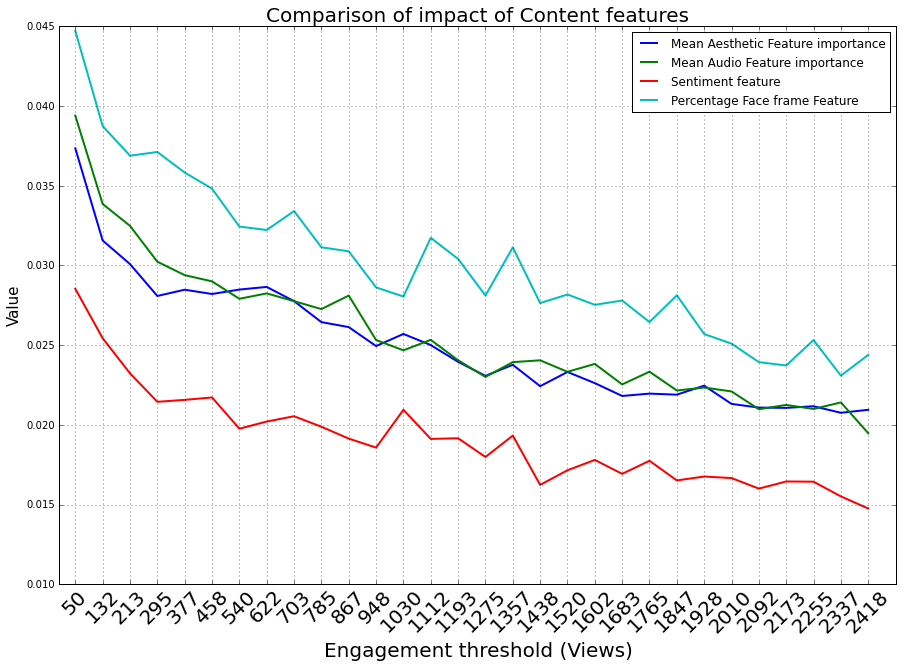

In [186]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of impact of Content features", fontsize = 20)
plt.xlabel("Engagement threshold (Views)",fontsize = 20)
plt.ylabel("Value",fontsize = 15)

aesthetic_feature_importance = [np.sum(feature_importance_total[i,:10]) for i in range(feature_importance_total.shape[0])]
indexAesthetic =  [np.argmax(feature_importance_total[i,:10]) for i in range(feature_importance_total.shape[0])]
#aesthetic_feature_importance = aesthetic_feature_importance / np.max(aesthetic_feature_importance)

audio_feature_importance = [np.sum(feature_importance_total[i,10:16]) for i in range(feature_importance_total.shape[0])]
indexAudio = [np.argmax(feature_importance_total[i,10:16]) for i in range(feature_importance_total.shape[0])]
#audio_feature_importance = audio_feature_importance / np.max(audio_feature_importance)

sentiment_feature_importance = [feature_importance_total[i,16] for i in range(feature_importance_total.shape[0])]

face_feature_importance = [feature_importance_total[i,17] for i in range(feature_importance_total.shape[0])]
#sentiment_feature_importance = sentiment_feature_importance/ np.max(sentiment_feature_importance)

print len(content_feature_importance)
#x = np.array(np.arange(0.2*medianPopReposts , 1.5*medianPopReposts , (1.5*medianPopReposts-0.2*medianPopReposts)/steps))

plt.plot(x , aesthetic_feature_importance,linewidth = 2)
plt.plot(x , audio_feature_importance,linewidth = 2)
plt.plot(x , sentiment_feature_importance,linewidth = 2)
plt.plot(x , face_feature_importance,linewidth = 2)



#plt.yticks(np.arange(0,0.11,0.01) , fontsize =  20 )
plt.xticks( x ,rotation=45 , fontsize =  20 )
plt.grid(True)
plt.legend(['Mean Aesthetic Feature importance', 'Mean Audio Feature importance' ,'Sentiment feature' , 'Percentage Face frame Feature' 
           ])
plt.show()

30


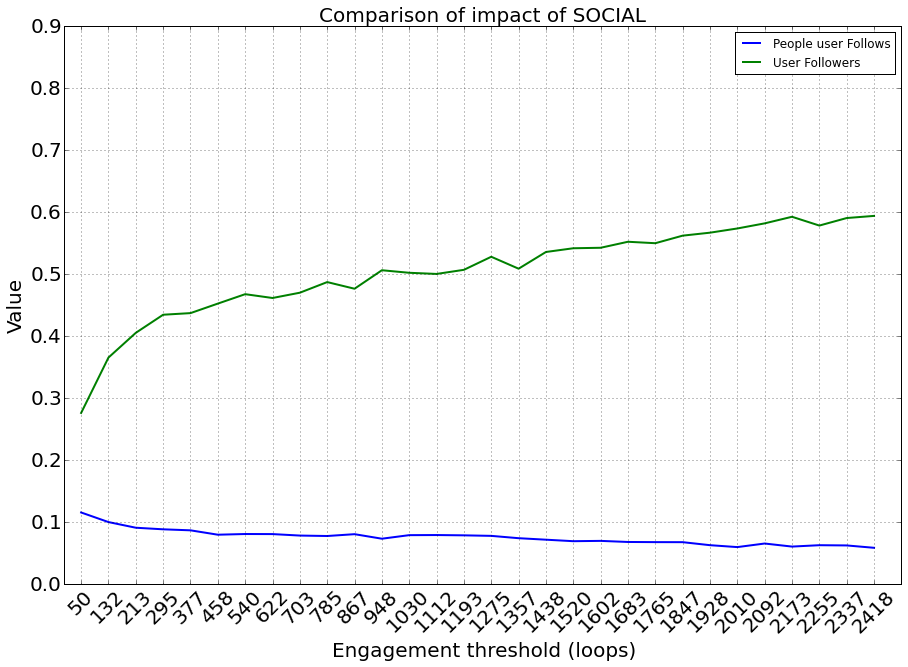

In [189]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of impact of SOCIAL", fontsize = 20)
plt.xlabel("Engagement threshold (loops)",fontsize = 20)
plt.ylabel("Value",fontsize = 20)

follower_feature_importance = [feature_importance_total[i,18] for i in range(feature_importance_total.shape[0])]
pastPosts_feature_importance = [feature_importance_total[i,19] for i in range(feature_importance_total.shape[0])]
print len(content_feature_importance)
#x = np.array(np.arange(0.2*medianPopReposts , 1.5*medianPopReposts , (1.5*medianPopReposts-0.2*medianPopReposts)/steps))

plt.plot(x , follower_feature_importance,linewidth = 2)
plt.plot(x , pastPosts_feature_importance,linewidth = 2)
plt.yticks(np.arange(0,1,0.1) , fontsize =  20 )
plt.xticks( x ,rotation=45 , fontsize =  20 )
plt.grid(True)
plt.legend(['People user Follows', 'User Followers', 
           ])
plt.show()

In [190]:
print indexAesthetic
print indexAudio

[3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 2, 2]


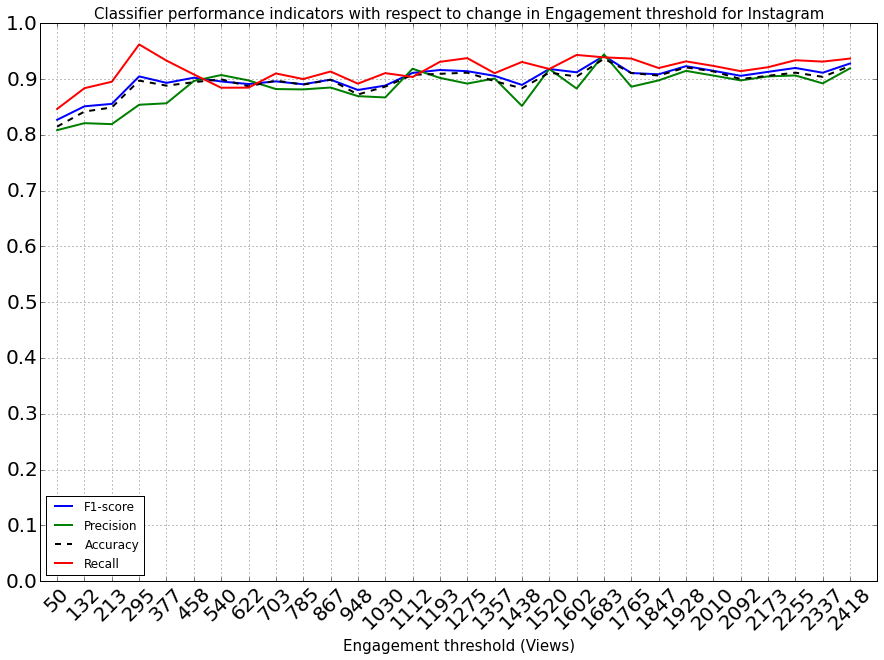

In [192]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Classifier performance indicators with respect to change in Engagement threshold for Instagram", fontsize = 15)
plt.xlabel("Engagement threshold (Views)",fontsize = 15)
plt.ylabel("",fontsize = 20)

#x = np.array(np.arange(0.2*medianPopReposts , 1.5*medianPopReposts , (1.5*medianPopReposts-0.2*medianPopReposts)/steps))

#plt.plot(x[:-2] , accuracies_total[:-2],linewidth = 1.5)
#plt.plot(x[:-2] , errors_total[:-2],linewidth = 1.5)
plt.plot(x[:] , fscores_total[:],linewidth = 2)
plt.plot(x[:] , precision_total[:],linewidth = 2)
plt.plot(x[:] , accuracies_total[:],linewidth = 2 , ls = 'dashed' , color = 'black')
plt.plot(x[:] , recall_total[:],linewidth = 2)

# plt.plot(x[:] , fscores_total_thirds[:],linewidth = 2)
# plt.plot(x[:] , precision_total_thirds[:],linewidth = 2)
# plt.plot(x[:] , accuracies_total_thirds[:],linewidth = 2, ls = 'dotted' , color = 'black')
# plt.plot(x[:] , recall_total_thirds[:],linewidth = 2)

plt.yticks(y, fontsize =  20 )
plt.xticks( x , rotation=45, fontsize =  20  )
plt.legend(['F1-score', 'Precision', 'Accuracy', 'Recall'      
           ] , loc = 3)
plt.grid(True)
plt.show()

In [ ]:
corr_loopLike , corr_likeRepo , corr_repoLoop = findIterativeCorrelations(labelNumbers , 2, 80  , 1*medianPopLoops , 25 )

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Variation of correlations between popularity indices with respect to change in threshold", fontsize = 15)
plt.xlabel("Popularity threshold Ranging from Median of entire dataset to Median of gold standard ",fontsize = 15)
plt.ylabel("Pearson Correlation coeff.",fontsize = 15)
plt.plot(corr_loopLike,linewidth = 1.5)
plt.plot(corr_likeRepo,linewidth = 1.5)
plt.plot(corr_repoLoop,linewidth = 1.5)

plt.legend(['Corr Between Loops and Likes', 'Corr Between Likes and Reposts', 'Corr Between Reposts and Loops'   
           ])
plt.grid(True)
plt.show()

In [ ]:

scipy.stats.pearsonr(FeatureMatrix[:,26] , labelNumbers[:,2] )

In [ ]:
faceCorrs , facePvalues = findIterativeCorrelations(FeatureMatrix , labelNumbers , 0, 20, 80.0 , 1.5*medianPopLoops, 30 )

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Variation of correlations between popularity indices with respect to change in threshold", fontsize = 15)
plt.xlabel("Popularity threshold Ranging from Median of entire dataset to Median of gold standard ",fontsize = 15)
plt.ylabel("Pearson Correlation coeff.",fontsize = 15)
plt.plot(faceCorrs,linewidth = 1.5)

plt.legend(['Corr Between Loops and Likes', 'Corr Between Likes and Reposts', 'Corr Between Reposts and Loops'   
           ])
plt.grid(True)
plt.show()